# ***Imports***

In [100]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

from torchvision import datasets, transforms

import matplotlib.pyplot as plt

In [101]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 256
EPOCHS = 20

print("Using device:", DEVICE)

Using device: cuda


# ***Helper Functions***

In [102]:
def load_dataset(dataset_name):
    if dataset_name == 'mnist':
        transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,)), transforms.Lambda(lambda x: x.view(-1))])
        train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
        test_dataset = datasets.MNIST('./data', train=False, download=True, transform=transform)


    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

    return train_loader, test_loader

In [103]:
class AutoEncoder(nn.Module):
    def __init__(self, size):
        super(AutoEncoder, self).__init__()
        self.ec1 = nn.Linear(size, size//2)
        self.ec2 = nn.Linear(size//2, size//4)

        self.dc1 = nn.Linear(size//4, size//2)
        self.dc2 = nn.Linear(size//2, size)

        self.activation = nn.LeakyReLU(0.2)

        self.activation_tanh = nn.Tanh()

    def forward(self, x):
        x = self.activation(self.ec1(x))
        x = self.activation(self.ec2(x))
        x = self.activation(self.dc1(x))
        recon = self.activation_tanh(self.dc2(x))

        return recon

In [104]:
def train(model, data_loader, optimizer, criterion):
    model.train()
    running_loss = 0.0
    for batch_idx, (data, _) in enumerate(data_loader):
        data = data.to(DEVICE)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, data)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    epoch_loss = running_loss / len(data_loader.dataset)

    return epoch_loss

In [105]:
def test(model, data_loader, criterion):
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for data, _ in data_loader:
            data = data.to(DEVICE)
            output = model(data)
            loss = criterion(output, data)

            running_loss += loss.item()

    epoch_loss = running_loss / len(data_loader.dataset)

    return epoch_loss

In [106]:
def train_model(model, train_loader, test_loader, optimizer, criterion, epochs):
    best_test_loss = 1e+6

    metrics = {
        'train_loss': [],
        'test_loss': [],
    }

    metric_best = {
        'train_loss': 0.0,
        'test_loss': 0.0,
    }

    for epoch in range(epochs):
        train_loss = train(model, train_loader, optimizer, criterion)
        test_loss = test(model, test_loader, criterion)

        if test_loss < best_test_loss:
            best_test_acc = test_loss
            metric_best['train_loss'] = train_loss
            metric_best['test_loss'] = test_loss

        metrics['train_loss'].append(train_loss)
        metrics['test_loss'].append(test_loss)

        print(f'Epoch {epoch+1}/{epochs}')
        print(f'Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}\n')

    return metrics, metric_best

In [107]:
def plot_metric(metrics):
    plt.plot(metrics['train_loss'], label='Train Loss')
    plt.plot(metrics['test_loss'], label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

In [108]:
def plot_reconstruction(model, data_loader):
    model.eval()
    data_each_class = {}

    with torch.no_grad():
        for data, target in data_loader:
            data = data.to(DEVICE)
            output = model(data)

            for i in range(len(data)):
                if target[i].item() not in data_each_class:
                    data_each_class[target[i].item()] = (data[i].cpu().numpy(), output[i].cpu().numpy())

    fig, axs = plt.subplots(2, 10, figsize=(20, 5))
    fig.suptitle("Original vs Reconstructed Images")

    for i in range(10):
        axs[0, i].imshow(data_each_class[i][0].reshape(28, 28), cmap='gray')
        axs[0, i].axis('off')
        axs[0, i].set_title(f"Digit {i}")

        axs[1, i].imshow(data_each_class[i][1].reshape(28, 28), cmap='gray')
        axs[1, i].axis('off')

    plt.show()

In [109]:
def main():
    train_loader, test_loader = load_dataset('mnist')
    model = AutoEncoder(size=28*28).to(DEVICE)
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    criterion = nn.MSELoss()

    metrics, metric_best = train_model(model, train_loader, test_loader, optimizer, criterion, EPOCHS)
    plot_metric(metrics)

    print("\nBEST METRIC")
    print(f'Train Loss: {metric_best["train_loss"]:.4f}, Test Loss: {metric_best["test_loss"]:.4f}')

    return model, test_loader

Epoch 1/20
Train Loss: 0.0005, Test Loss: 0.0002

Epoch 2/20
Train Loss: 0.0001, Test Loss: 0.0001

Epoch 3/20
Train Loss: 0.0001, Test Loss: 0.0001

Epoch 4/20
Train Loss: 0.0001, Test Loss: 0.0001

Epoch 5/20
Train Loss: 0.0001, Test Loss: 0.0001

Epoch 6/20
Train Loss: 0.0001, Test Loss: 0.0001

Epoch 7/20
Train Loss: 0.0001, Test Loss: 0.0000

Epoch 8/20
Train Loss: 0.0000, Test Loss: 0.0000

Epoch 9/20
Train Loss: 0.0000, Test Loss: 0.0000

Epoch 10/20
Train Loss: 0.0000, Test Loss: 0.0000

Epoch 11/20
Train Loss: 0.0000, Test Loss: 0.0000

Epoch 12/20
Train Loss: 0.0000, Test Loss: 0.0000

Epoch 13/20
Train Loss: 0.0000, Test Loss: 0.0000

Epoch 14/20
Train Loss: 0.0000, Test Loss: 0.0000

Epoch 15/20
Train Loss: 0.0000, Test Loss: 0.0000

Epoch 16/20
Train Loss: 0.0000, Test Loss: 0.0000

Epoch 17/20
Train Loss: 0.0000, Test Loss: 0.0000

Epoch 18/20
Train Loss: 0.0000, Test Loss: 0.0000

Epoch 19/20
Train Loss: 0.0000, Test Loss: 0.0000

Epoch 20/20
Train Loss: 0.0000, Test Los

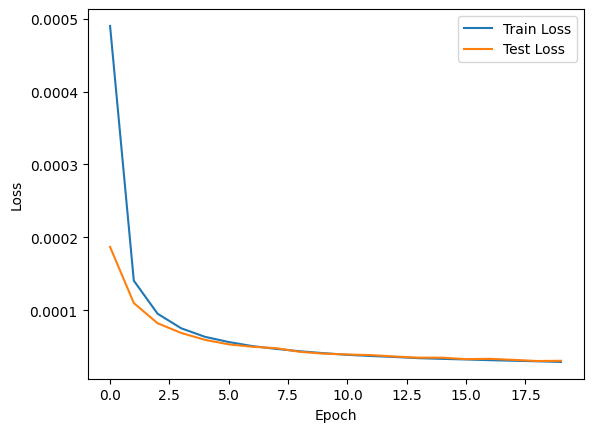


BEST METRIC
Train Loss: 0.0000, Test Loss: 0.0000


In [110]:
model, test_loader = main()

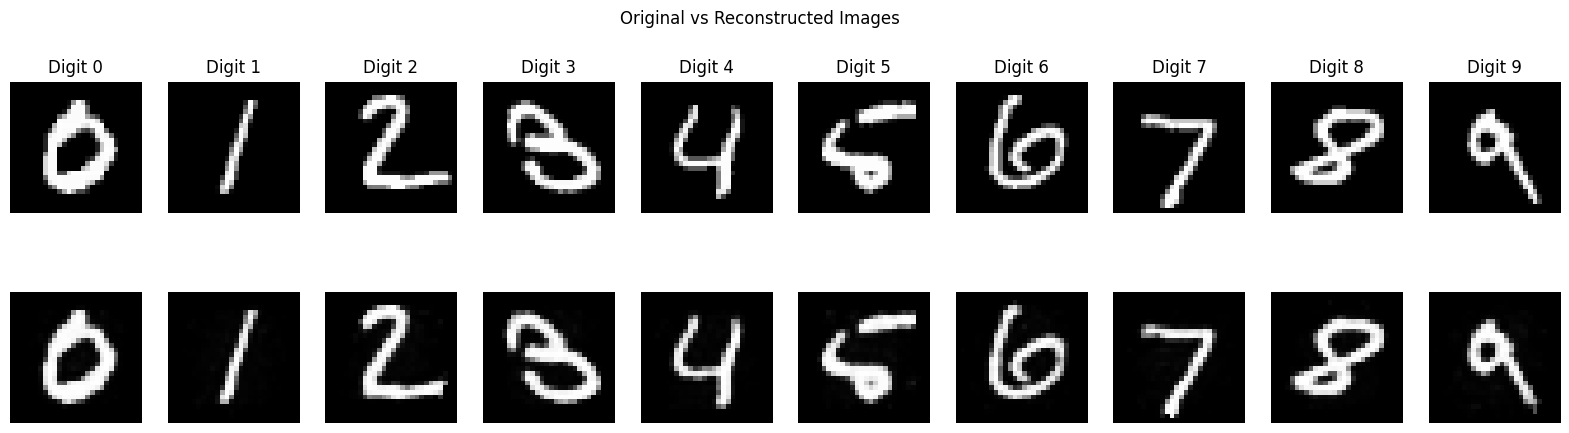

In [111]:
plot_reconstruction(model, test_loader)